In [368]:
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
import re
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
!pip install pandas matplotlib seaborn nltk wordcloud openpyxl
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
!pip install textblob
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

  Using cached matplotlib-3.7.5-cp38-cp38-win_amd64.whl (7.5 MB)


ERROR: matplotlib 3.7.5 has requirement numpy<2,>=1.20, but you'll have numpy 1.18.5 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\kosto\\anaconda3\\Lib\\site-packages\\matplotlib\\ft2font.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kosto\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kosto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kosto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kosto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading

True

## Display the data

In [518]:
# Read the CSV file into a DataFrame
#yelp_df = pd.read_csv('yelp_total.csv')
yelp_df = pd.read_csv('yelpNY_data.csv')

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(yelp_df.head())

# Display information about the DataFrame
print("\nInformation about the DataFrame:")
print(yelp_df.info())

# Display the type of the DataFrame
print("\nType of the DataFrame:", type(yelp_df))



First few rows of the DataFrame:
                            Name  Rating                              Address  \
0  Da Andrea - Greenwich Village     4.3     35 W 13th St, New York, NY 10011   
1                 Joe's Shanghai     3.8     46 Bowery St, New York, NY 10013   
2                       Rubirosa     4.3  235 Mulberry St, New York, NY 10012   
3                          Kalye     4.6    251 Broome St, New York, NY 10002   
4                           Raku     4.5     342 E 6th St, New York, NY 10003   

                                             Reviews  
0  ['This place is wonderful. The atmosphere is g...  
1  ['If I could rate this 11/10- I WOULD!!! The f...  
2  ['Great food, incredible music and ambiance. P...  
3  ['Very very delicious and fun experience! \n\n...  
4  ['Food si really good, service is cool. Do not...  

Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column 

#### preprocessing

In [519]:
yelp_df['Name']=yelp_df['Name'].astype(str)
yelp_df['Address']=yelp_df['Address'].astype(str)
yelp_df['Reviews']=yelp_df['Reviews'].astype(str)

# Function to preprocess text
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^a-zA-Z\s]','',text)
    # Convert text to lowercase
    text = text.lower()
    return text

yelp_df[['Name', 'Address', 'Reviews']] = yelp_df[['Name', 'Address','Reviews']].applymap(preprocess_text)
yelp_df = yelp_df[yelp_df['Reviews'].apply(lambda x: len(x) > 0)]

In [520]:
def preprocess_Rev(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha()]  # Ensuring token is alphabetic
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

yelp_df['Clean_Review'] = yelp_df['Reviews'].apply(preprocess_Rev)
yelp_df.head()


,Name,Rating,Address,Reviews,Clean_Review
0,da andrea greenwich village,4.3,w th st new york ny,this place is wonderful the atmosphere is grea...,"[place, wonderful, atmosphere, great, food, ev..."
1,joes shanghai,3.8,bowery st new york ny,if i could rate this i would the food here wa...,"[could, rate, would, food, absolutely, phenome..."
2,rubirosa,4.3,mulberry st new york ny,great food incredible music and ambiance pizza...,"[great, food, incredible, music, ambiance, piz..."
3,kalye,4.6,broome st new york ny,very very delicious and fun experience nnwe st...,"[delicious, fun, experience, nnwe, stumbled, u..."
4,raku,4.5,e th st new york ny,food si really good service is cool do not rec...,"[food, si, really, good, service, cool, recomm..."


In [521]:
data = yelp_df['Rating'].value_counts().sort_index(ascending=False)

trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / yelp_df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values
               )

# Create layout

layout = dict(title = 'Distribution Of {} Restaurant Ratings from Yelp Users'.format(yelp_df.shape[0]),
              xaxis = dict(title = 'Count'),
              yaxis = dict(title = 'Rating / Stars'))

# Create distribution plot

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## Sentiment Analysis:

### Positive Reviews:

In [522]:
# Filtering for negative reviews (one and two star)
one_rate_reviews = yelp_df[yelp_df['Rating'] == 1.0]
two_rate_reviews = yelp_df[yelp_df['Rating'] == 2.0]
negative_reviews = pd.concat([one_rate_reviews, two_rate_reviews])

# Adding a new column indicating sentiment
yelp_df['Rating_Category'] = 'neutral'
yelp_df.loc[yelp_df['Rating'] <= 2, 'Rating_Category'] = 'negative'
yelp_df.loc[yelp_df['Rating'] >= 4, 'Rating_Category'] = 'positive'

yelp_df['Rating_Category'].value_counts()

positive    423
neutral      67
Name: Rating_Category, dtype: int64

In [523]:
Positiv_Rate_Data = yelp_df[yelp_df['Rating_Category']=='positive']
Positiv_Rate_Data.head()

,Name,Rating,Address,Reviews,Clean_Review,Rating_Category
0,da andrea greenwich village,4.3,w th st new york ny,this place is wonderful the atmosphere is grea...,"[place, wonderful, atmosphere, great, food, ev...",positive
2,rubirosa,4.3,mulberry st new york ny,great food incredible music and ambiance pizza...,"[great, food, incredible, music, ambiance, piz...",positive
3,kalye,4.6,broome st new york ny,very very delicious and fun experience nnwe st...,"[delicious, fun, experience, nnwe, stumbled, u...",positive
4,raku,4.5,e th st new york ny,food si really good service is cool do not rec...,"[food, si, really, good, service, cool, recomm...",positive
5,antidote,4.6,s nd st brooklyn ny,i had the pleasure to dine at antidote tonight...,"[pleasure, dine, antidote, tonight, place, bus...",positive


In [524]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words for Positive reviews')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

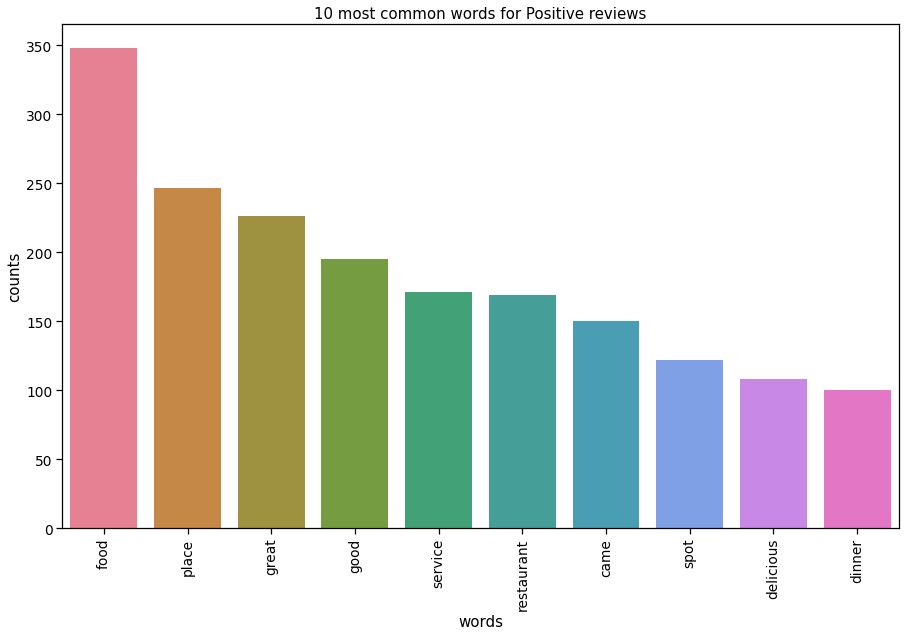

In [525]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(Positiv_Rate_Data['Reviews'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

#### אנשים מדרגים דירוג גבוה והביקורת שלהם שלילית


#### crate the sentiment polarity of the Reviews

In [526]:
# Function for sentiment analysis
def perform_sentiment_analysis(text):
    """
    Perform sentiment analysis on a given text using TextBlob.

    Parameters:
    - text (str): The text to analyze.

    Returns:
    - str: Sentiment category ('negative', 'neutral', 'positive').
    """
    sentiment_score = TextBlob(text).sentiment.polarity
    if sentiment_score < 0:
        return 'negative'
    elif sentiment_score == 0:
        return 'neutral'
    else:
        return 'positive'


# Step 1: Perform sentiment analysis for each response
yelp_df['Sentiment'] = yelp_df['Reviews'].apply(perform_sentiment_analysis)
yelp_df['Sentiment_Score']= yelp_df['Reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)
yelp_df['subjective']= yelp_df['Reviews'].apply(lambda x: TextBlob(x).subjectivity)

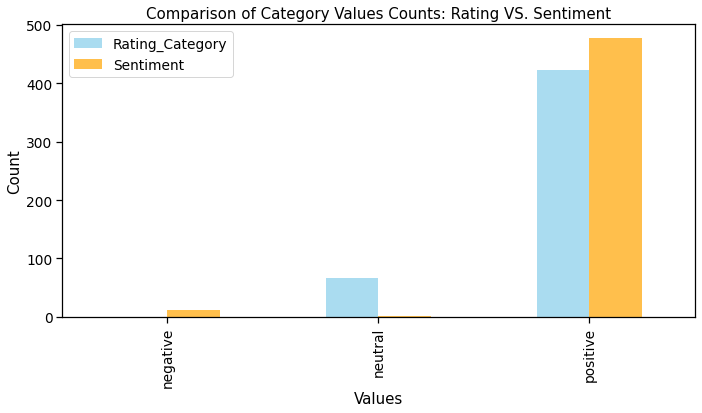

In [527]:
# Counting occurrences of values in each column
counts_column1 = yelp_df['Rating_Category'].value_counts()
counts_column2 = yelp_df['Sentiment'].value_counts()

# Combining counts into a single DataFrame
combined_counts = pd.DataFrame({'Rating_Category': counts_column1, 'Sentiment': counts_column2}).fillna(0)

# Plotting the bar plot
combined_counts.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7,figsize=(10, 6))
    
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Comparison of Category Values Counts: Rating VS. Sentiment')

plt.tight_layout()
plt.show()



### all data sentiment

### Proportion of Reviews by Sentiment Category and Rating

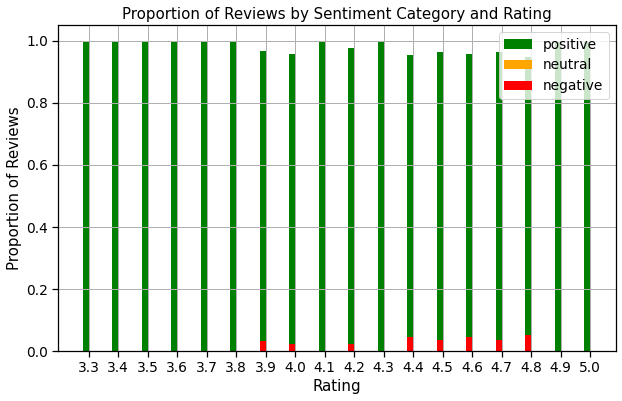

<ipython-input-528-d19eb55001bc>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [528]:
average_score_df = yelp_df.groupby(['Rating', 'Sentiment']).size().unstack().fillna(0)
total_reviews_per_rating = yelp_df['Rating'].value_counts()
average_score_df = average_score_df.div(total_reviews_per_rating, axis=0)

ratings = average_score_df.index
bar_width = 0.2
index = np.arange(len(ratings))
colors = {'positive': 'green', 'neutral': 'orange', 'negative': 'red'}

plt.figure(figsize=(10, 6))

for sentiment, color in colors.items():
    if sentiment in average_score_df.columns:
        plt.bar(index - bar_width / 2, average_score_df[sentiment], bar_width, color=color, label=sentiment)

plt.xlabel('Rating')
plt.ylabel('Proportion of Reviews')
plt.title('Proportion of Reviews by Sentiment Category and Rating')
plt.xticks(index, ratings)
plt.legend()
plt.grid(True)
plt.show()

# Step 3: Display the graph in a meaningful way
X = yelp_df[['Rating', 'Sentiment']]
X['Sentiment'] = X['Sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


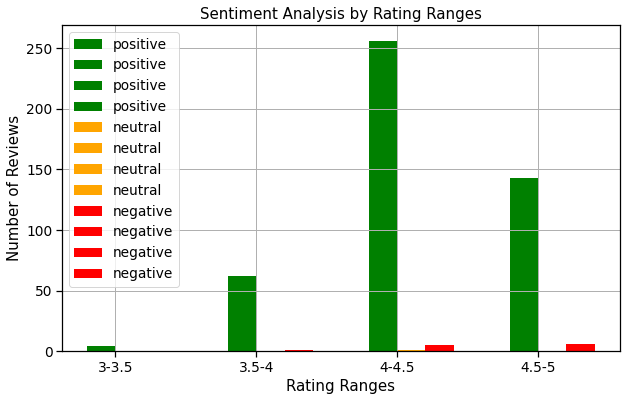

In [529]:
rating_ranges = [(3, 3.5), (3.5, 4), (4, 4.5), (4.5, 5)]

# Initialize sentiment counts for each range
sentiment_counts = {'negative': np.zeros(4), 'neutral': np.zeros(4), 'positive': np.zeros(4)}

# Count sentiment categories in each range
for i, (lower, upper) in enumerate(rating_ranges):
    subset = yelp_df[(yelp_df['Rating'] >= lower) & (yelp_df['Rating'] < upper)]
    for sentiment in ['negative', 'neutral', 'positive']:
        sentiment_counts[sentiment][i] = subset[subset['Sentiment'] == sentiment].shape[0]

# Plotting the column graph
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(rating_ranges))
colors = {'positive': 'green', 'neutral': 'orange', 'negative': 'red'}

for i, (sentiment, color) in enumerate(colors.items()):
    for j, (lower, upper) in enumerate(rating_ranges):
        subset = yelp_df[(yelp_df['Rating'] >= lower) & (yelp_df['Rating'] < upper)]
        sentiment_count = subset[subset['Sentiment'] == sentiment].shape[0]
        plt.bar(index[j] + i * bar_width, sentiment_count, bar_width, color=color, label=sentiment)

plt.xlabel('Rating Ranges')
plt.ylabel('Number of Reviews')
plt.title('Sentiment Analysis by Rating Ranges')
plt.xticks(index + bar_width / 2, [f'{lower}-{upper}' for lower, upper in rating_ranges])
plt.legend()
plt.grid(True)
plt.show()

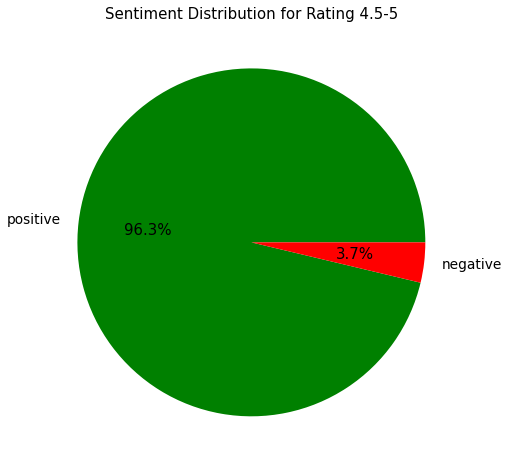

In [530]:
# Pie chart of the rating 4.5-5 in percentages
# Filter data for rating 4.5-5
rating_45_5 = yelp_df[(yelp_df['Rating'] >= 4.5) & (yelp_df['Rating'] <= 5)]

# Count sentiment categories for rating 4.5-5
sentiment_counts_rating_45_5 = rating_45_5['Sentiment'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts_rating_45_5, labels=sentiment_counts_rating_45_5.index, autopct='%1.1f%%', colors=['green', 'red', 'orange'])
plt.title('Sentiment Distribution for Rating 4.5-5')
plt.show()

## methodology

In [516]:
# Assuming df is your DataFrame containing the reviews
# Replace 'review_count' with the actual column name containing the review texts
review_texts = yelp_df['Reviews'].fillna('')

# Initialize CountVectorizer for N-grams (you can specify ngram_range)
ngram_vectorizer = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(2,3))

# Fit and transform the review texts to get the N-gram features
ngram_features = ngram_vectorizer.fit_transform(review_texts)

count_values= ngram_features.toarray().sum(axis=0)
vocab= ngram_vectorizer.vocabulary_
ngram_df = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0:'freqenecy', 1:'bigram/trigram'})

ngram_df['Sentiment']= ngram_df['bigram/trigram'].apply(lambda x: TextBlob(x).sentiment.polarity)
ngram_df['subjective']= ngram_df['bigram/trigram'].apply(lambda x: TextBlob(x).subjectivity)
ngram_df
# Convert the N-gram features to DataFrame for visualization (optional)
#ngram_df = pd.DataFrame(ngram_features.toarray(), columns=ngram_vectorizer.get_feature_names_out())

,freqenecy,bigram/trigram,Sentiment,subjective
0,25,new york,0.136364,0.454545
1,24,happy hour,0.800000,1.000000
2,23,first time,0.250000,0.333333
3,21,food great,0.800000,0.750000
4,20,great service,0.800000,0.750000
...,...,...,...,...
35530,1,able dine,0.500000,0.625000
35531,1,abcwhite clientele nits,0.000000,0.000000
35532,1,abcwhite clientele,0.000000,0.000000
35533,1,abandoned another person,0.000000,0.000000


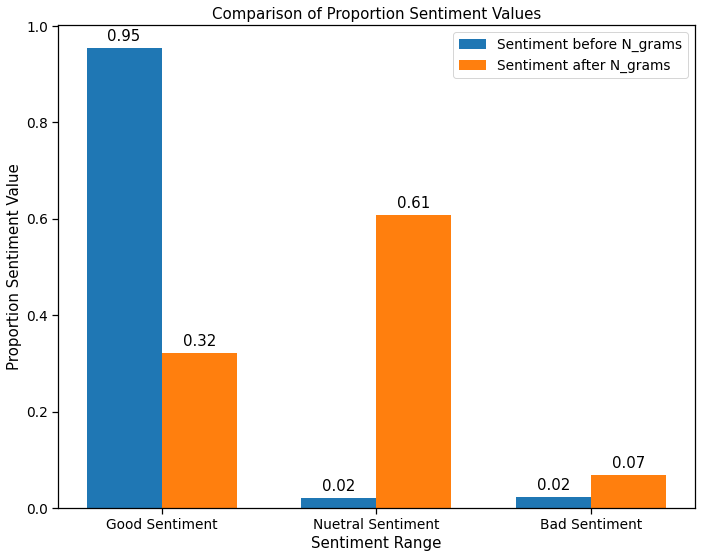

In [386]:
# Define ranges for "good" and "bad" sentiment values
good_range = (0.0001, 1.0)  # Example: sentiment values from 0.5 to 1.0 are considered "good"
nuetral_range = (0.0, 0.0)
bad_range = (-1.0, -0.0001)  # Example: sentiment values from -1.0 to 0.0 are considered "bad"


len_sentiment_score= yelp_df['Sentiment_Score'].count()

# Calculate average sentiment values for each range in both DataFrames
p_good_df1 = yelp_df[(yelp_df['Sentiment_Score'] >= good_range[0]) & (yelp_df['Sentiment_Score'] <= good_range[1])]['Sentiment_Score'].count()/len_sentiment_score
p_bad_df1 = yelp_df[(yelp_df['Sentiment_Score'] >= bad_range[0]) & (yelp_df['Sentiment_Score'] <= bad_range[1])]['Sentiment_Score'].count()/len_sentiment_score
p_nuetal_df1 = yelp_df[(yelp_df['Sentiment_Score'] >= nuetral_range[0]) & (yelp_df['Sentiment_Score'] <= nuetral_range[1])]['Sentiment_Score'].count()/len_sentiment_score

len_sentiment_score_n= ngram_df['Sentiment'].count()
p_good_df2 = ngram_df[(ngram_df['Sentiment'] >= good_range[0]) & (ngram_df['Sentiment'] <= good_range[1])]['Sentiment'].count()/len_sentiment_score_n
p_bad_df2 = ngram_df[(ngram_df['Sentiment'] >= bad_range[0]) & (ngram_df['Sentiment'] <= bad_range[1])]['Sentiment'].count()/len_sentiment_score_n
p_nuetral_df2 = ngram_df[(ngram_df['Sentiment'] >= nuetral_range[0]) & (ngram_df['Sentiment'] <= nuetral_range[1])]['Sentiment'].count()/len_sentiment_score_n


# Create lists of average sentiment values for plotting
categories = ['Good Sentiment','Nuetral Sentiment', 'Bad Sentiment']
p_df1_values = [p_good_df1, p_nuetal_df1,p_bad_df1]
p_df2_values = [p_good_df2, p_nuetral_df2,p_bad_df2]

# Plot the comparison of average sentiment values in both DataFrames
plt.figure(figsize=(10, 8))
bar_width = 0.35
index = range(len(categories))


bars1 = plt.bar(index, p_df1_values, bar_width, label='Sentiment before N_grams')
bars2 = plt.bar([i + bar_width for i in index], p_df2_values, bar_width, label='Sentiment after N_grams')


# Annotate bars with mean values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate('{}'.format(round(height, 2)),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 4),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel('Sentiment Range')
plt.ylabel('Proportion Sentiment Value')
plt.title('Comparison of Proportion Sentiment Values')
plt.xticks([i + bar_width / 2 for i in index], categories)
plt.legend()
plt.tight_layout()
plt.show()


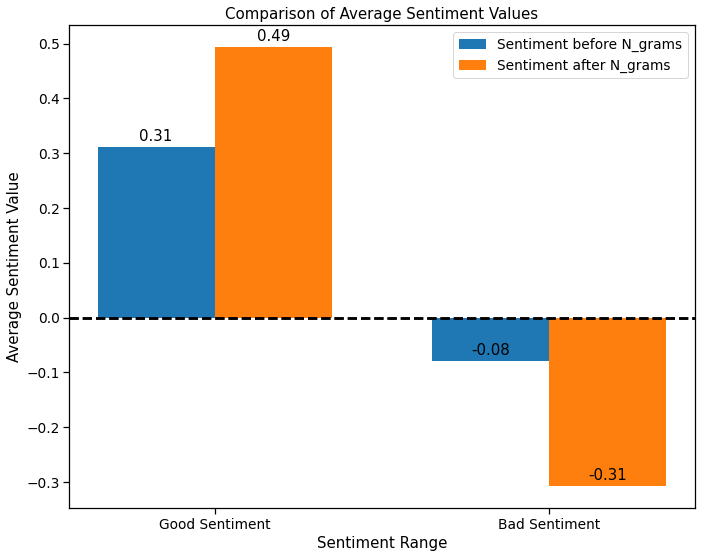

In [517]:
# Define ranges for "good" and "bad" sentiment values
good_range = (0.0001, 1.0)  # Example: sentiment values from 0.5 to 1.0 are considered "good"
bad_range = (-1.0, -0.0001)  # Example: sentiment values from -1.0 to 0.0 are considered "bad"

# Calculate average sentiment values for each range in both DataFrames
avg_good_df1 = yelp_df[(yelp_df['Sentiment_Score'] >= good_range[0]) & (yelp_df['Sentiment_Score'] <= good_range[1])]['Sentiment_Score'].mean()
avg_bad_df1 = yelp_df[(yelp_df['Sentiment_Score'] >= bad_range[0]) & (yelp_df['Sentiment_Score'] <= bad_range[1])]['Sentiment_Score'].mean()

avg_good_df2 = ngram_df[(ngram_df['Sentiment'] >= good_range[0]) & (ngram_df['Sentiment'] <= good_range[1])]['Sentiment'].mean()
avg_bad_df2 = ngram_df[(ngram_df['Sentiment'] >= bad_range[0]) & (ngram_df['Sentiment'] <= bad_range[1])]['Sentiment'].mean()

# Create lists of average sentiment values for plotting
categories = ['Good Sentiment', 'Bad Sentiment']
avg_df1_values = [avg_good_df1, avg_bad_df1]
avg_df2_values = [avg_good_df2, avg_bad_df2]

# Plot the comparison of average sentiment values in both DataFrames
plt.figure(figsize=(10, 8))
bar_width = 0.35
index = range(len(categories))

plt.axhline(0, color='black', linestyle='--')

bars1 = plt.bar(index, avg_df1_values, bar_width, label='Sentiment before N_grams')
bars2 = plt.bar([i + bar_width for i in index], avg_df2_values, bar_width, label='Sentiment after N_grams')

# Add a black line at y=0.0
plt.axhline(0, color='black', linestyle='--')

# Annotate bars with mean values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate('{}'.format(round(height, 2)),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel('Sentiment Range')
plt.ylabel('Average Sentiment Value')
plt.title('Comparison of Average Sentiment Values')
plt.xticks([i + bar_width / 2 for i in index], categories)
plt.legend()
plt.tight_layout()
plt.show()


## Clustering the reviews

#### Clustering the original review text

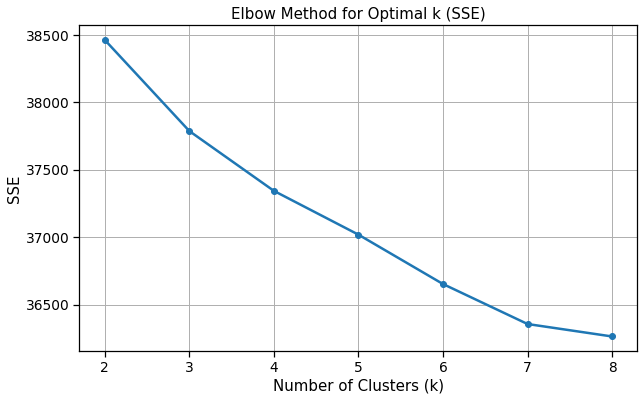

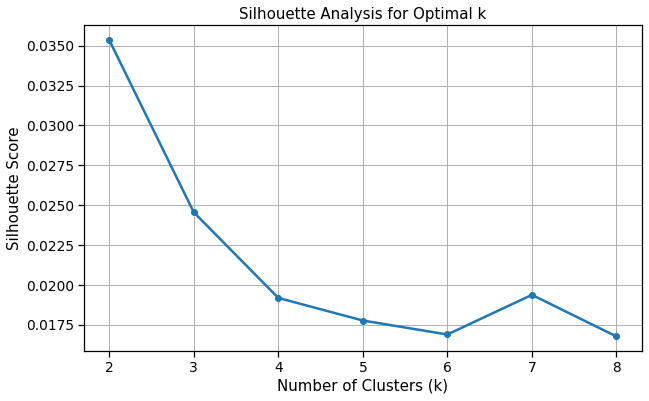

In [531]:
# Initialize CountVectorizer for converting text to vectors
vectorizer = CountVectorizer()

# Fit and transform the "Reviews" column to obtain the document-term matrix
X = vectorizer.fit_transform(yelp_df['Reviews'])

# Calculate SSE and Silhouette score for different values of k
k_values = range(2, 9)  
sse = []
silhouette_scores = []

for k in k_values:
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit KMeans to the data
    kmeans.fit(X)
    # Calculate SSE
    sse.append(kmeans.inertia_)
    # Calculate Silhouette score
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot SSE vs. number of clusters (k)
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Plot Silhouette score vs. number of clusters (k)
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')  # Use k_values without slicing
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()



### scatter the clusters according to the optimal k

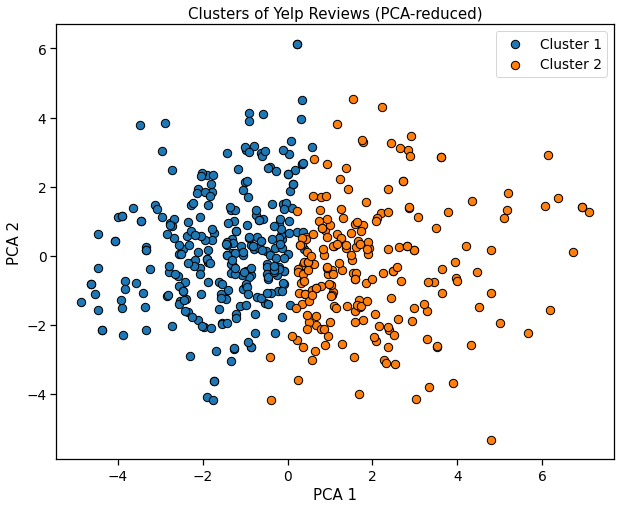

In [532]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plotting clusters
plt.figure(figsize=(10, 8))
for i in range(optimal_k):
    cluster = np.where(kmeans.labels_ == i)
    plt.scatter(X_pca[cluster, 0], X_pca[cluster, 1], label=f'Cluster {i+1}', edgecolor='k', s=70)
plt.title('Clusters of Yelp Reviews (PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


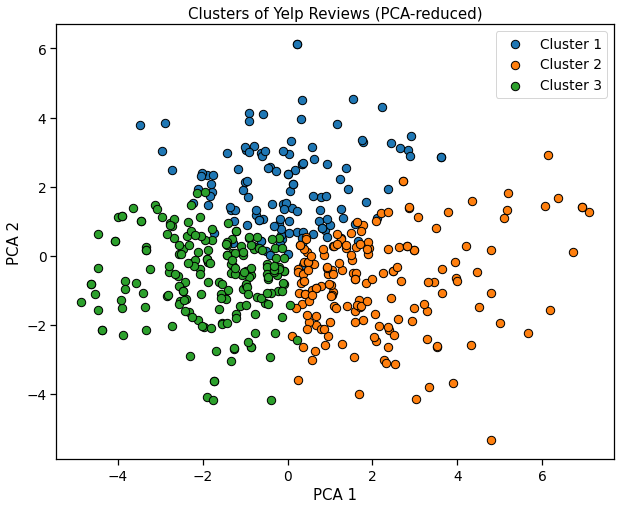

In [533]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plotting clusters
plt.figure(figsize=(10, 8))
for i in range(optimal_k):
    cluster = np.where(kmeans.labels_ == i)
    plt.scatter(X_pca[cluster, 0], X_pca[cluster, 1], label=f'Cluster {i+1}', edgecolor='k', s=70)
plt.title('Clusters of Yelp Reviews (PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


#### Clustering the tf-idf review text

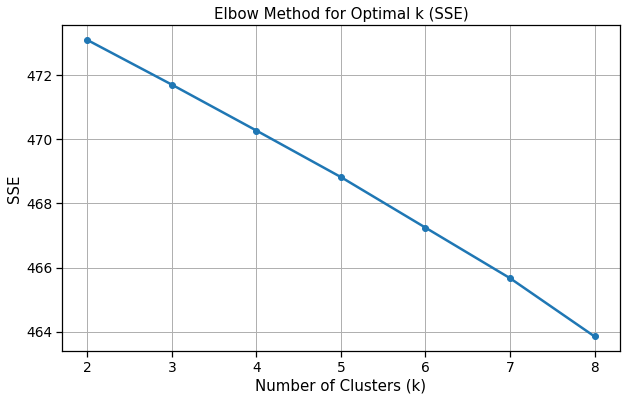

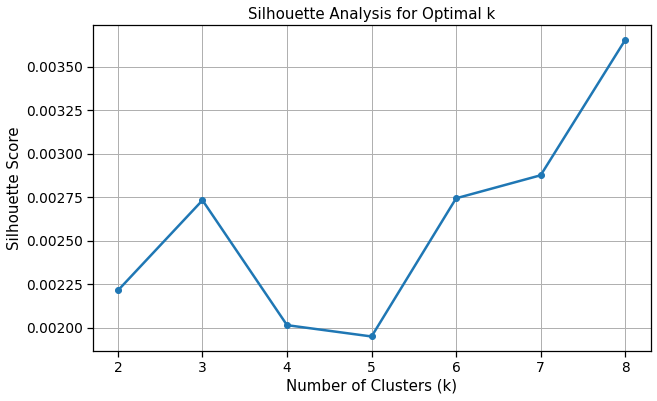

In [534]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(yelp_df['Reviews'])

# Calculate SSE and Silhouette score for different values of k
k_values = range(2, 9)  
sse = []
silhouette_scores = []

for k in k_values:
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit KMeans to the data
    kmeans.fit(tfidf_features)
    # Calculate SSE
    sse.append(kmeans.inertia_)
    # Calculate Silhouette score
    silhouette_scores.append(silhouette_score(tfidf_features, kmeans.labels_))

# Plot SSE vs. number of clusters (k)
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Plot Silhouette score vs. number of clusters (k)
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')  # Use k_values without slicing
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()


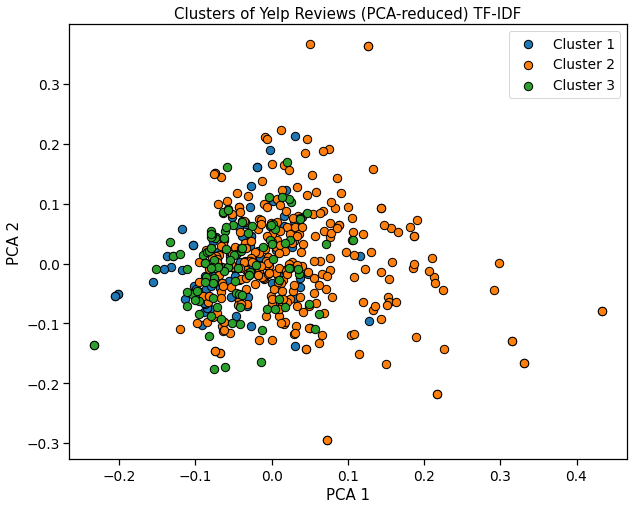

In [544]:

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(tfidf_features)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_features.toarray())

# Plotting clusters
plt.figure(figsize=(10, 8))
for i in range(optimal_k):
    cluster = np.where(kmeans.labels_ == i)
    plt.scatter(X_pca[cluster, 0], X_pca[cluster, 1], label=f'Cluster {i+1}', edgecolor='k', s=70)
plt.title('Clusters of Yelp Reviews (PCA-reduced) TF-IDF')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

#### Clustering the N-grams review text

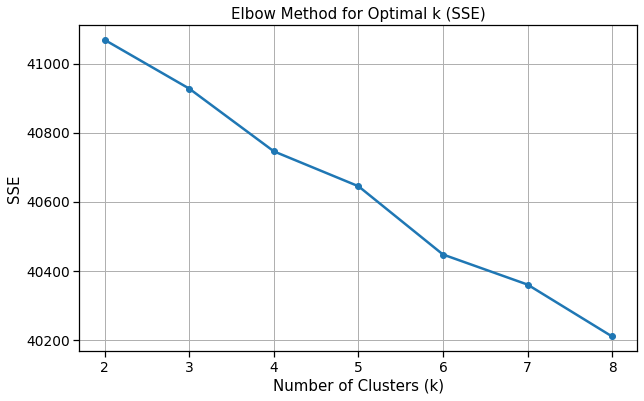

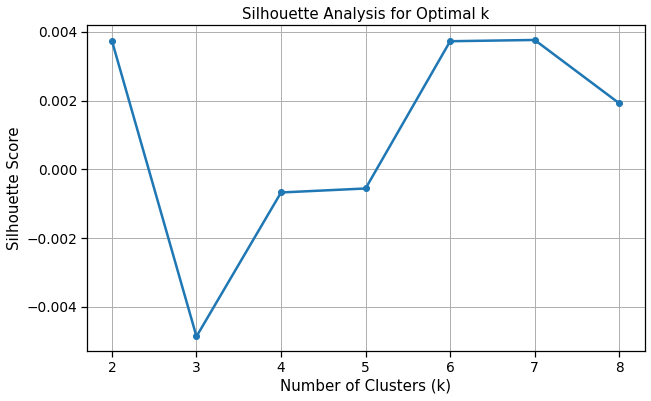

In [540]:

k_values = range(2, 9)  
sse = []
silhouette_scores = []

for k in k_values:
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit KMeans to the data
    kmeans.fit(ngram_features)
    # Calculate SSE
    sse.append(kmeans.inertia_)
    # Calculate Silhouette score
    silhouette_scores.append(silhouette_score(ngram_features, kmeans.labels_))

# Plot SSE vs. number of clusters (k)
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Plot Silhouette score vs. number of clusters (k)
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')  # Use k_values without slicing
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()


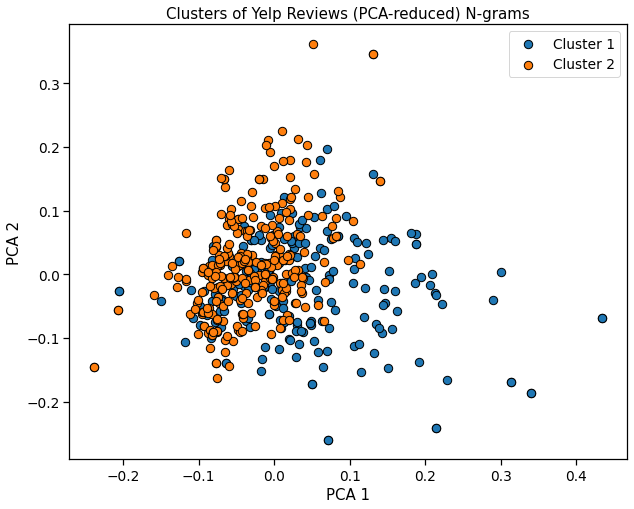

In [543]:

optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(tfidf_features)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_features.toarray())

# Plotting clusters
plt.figure(figsize=(10, 8))
for i in range(optimal_k):
    cluster = np.where(kmeans.labels_ == i)
    plt.scatter(X_pca[cluster, 0], X_pca[cluster, 1], label=f'Cluster {i+1}', edgecolor='k', s=70)
plt.title('Clusters of Yelp Reviews (PCA-reduced) N-grams')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()